In [1]:
import numpy as np
import nolds
from scipy import interpolate
from scipy import signal
import pandas as pd
import matplotlib.patches as mpatches
from collections import OrderedDict
from matplotlib import style
import matplotlib.pyplot as plt
import pylab as plot
style.use('ggplot')
params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
         'axes.titlesize' : 20,
          'axes.labelsize' : 10,
          'lines.linewidth' : 2,
          'lines.markersize' : 5,
          'xtick.labelsize' : 15,
          'ytick.labelsize' : 15}
plot.rcParams.update(params)

In [2]:
import json

# Load data example 
with open('data_example/2b3d7a98-a1fb-47ad-9705-4a91d448da9b_RrInterval_2018-07-03T160210842.json') as f:
    data = json.load(f)

import pandas as pd

data_field = data["data"]
# Split fields in timestamp & value
df_exploration = pd.DataFrame(list(map(lambda x: x.split(" "), data_field)), 
                              columns= ["timestamp", "RrInterval"])

# Cast value as int
df_exploration["RrInterval"] = df_exploration["RrInterval"].apply(lambda x : int(x))

# set cleaned timestamp as index
df_exploration["timestamp"] = pd.to_datetime(df_exploration["timestamp"])
df_exploration = df_exploration.set_index("timestamp")

df_exploration.sample(10)

,RrInterval
timestamp,
2018-07-03 16:17:19.540,700
2018-07-03 16:02:18.625,744
2018-07-03 16:05:07.844,737
2018-07-03 16:08:22.951,712
2018-07-03 16:03:24.435,699
2018-07-03 16:15:23.514,732
2018-07-03 16:03:19.566,724
2018-07-03 16:12:39.700,745
2018-07-03 16:07:59.388,755


# Pre processing to clean Outliers

In [4]:
def clean_outlier(RrIntervals, removing_rule = 0.2):
    """
    RR intervals differing by more than the removing_rule from the one proceeding 
    it are removed.
    
    Arguments
    ---------
    RrIntervals - list of Rr Intervals
    removing_rule - percentage criteria of difference with previous Rr Interval at 
    which we consider that it is abnormal
    
    Returns
    ---------
    NNIntervals - list of NN Interval

    """ 
    NNIntervals = []
    outlier_count = 0
    for i, rri in enumerate(RrIntervals):        
        if abs(rri - RrIntervals[i-1]) <= removing_rule * RrIntervals[i-1]:
            NNIntervals.append(rri)
        else:
            if i > 0 and i < len(RrIntervals):
                # A débattre, quelle gestion faire pour remplacer les outliers ?
                NNInterval = (RrIntervals[i-1] + RrIntervals[i+1]) / 2
                NNIntervals.append(NNInterval)
            outlier_count += 1
    print("Il y a {} outliers qui ont été supprimés".format(outlier_count))
    return NNIntervals


In [5]:
NNIntervals = clean_outlier(df_exploration["RrInterval"])

print(NNIntervals[:10])

Il y a 0 outliers qui ont été supprimés
[736, 730, 719, 704, 712, 718, 724, 734, 744, 759]


# Time Domain Features

In [6]:
def get_time_domain_features(NNIntervals):
    """
    Function returning a dictionnary containing time domain features for 
    HRV analyses.
    Must use this function on short term recordings, from 2 to 5 minutes 
    window.
    
    Arguments
    ----------
    NNIntervals - list of Normal to Normal Interval
    
    Returns
    ----------
    timeDomainFeaturess - dictionnary containing time domain features for 
    HRV analyses. Thera are details about each features below.
    
    Notes
    ----------
    Details about feature engineering...
    
    - **meanNN**: The the mean RR interval
    
    - **SDANN**: The standard deviation of the time interval between successive normal heart 
    beats (*i.e.*, the RR intervals)
    
    - **SDSD**: Standard deviation of differences between adjacent NN intervals
    
    - **RMSSD**: Root mean square of the RR intervals (*i.e.*, square root of the mean 
    of the squared differences in time between successive normal heart beats). Reflects high 
    frequency (fast or parasympathetic) influences on HRV (*i.e.*, those influencing larger 
    changes from one beat to the next).
    
    - **medianNN**: Median Absolute values of the successive Differences between the RR intervals.

    - **NN50**: Number of interval differences of successive RR intervals greater than 50 ms.

    - **pNN50**: The proportion derived by dividing NN50 (The number of interval differences of 
    successive RR intervals greater than 50 ms) by the total number of RR intervals.

    - **NN20**: Number of interval differences of successive RR intervals greater than 20 ms.

    - **pNN20**: The proportion derived by dividing NN20 (The number of interval differences of 
    successive RR intervals greater than 20 ms) by the total number of RR intervals.

    - **CVSD**: The coefficient of variation of successive differences (van Dellen et al., 1985), 
    the RMSSD divided by meanNN.
    
    - **RangeNN**: différence between the maximum and minimum NNInterval.
    
    
    References
    ----------
    TO DO
    
    """
    
    diff_nni = np.diff(NNIntervals)
    L = len(NNIntervals)
    
    meanNN = np.mean(NNIntervals)
    SDANN = np.std(NNIntervals, ddof=1) # ddof = 1 : estimateur non biaisé => divise std par n-1
    SDSD = np.std(diff_nni)
    RMSSD = np.sqrt(np.mean(diff_nni ** 2))
    medianNN = np.median(NNIntervals)
    
    NN50 = sum(abs(diff_nni) > 50)
    pNN50 = 100 * NN50 / L
    NN20 = sum(abs(diff_nni) > 20)
    pNN20 = 100 * NN20 / L
    
    RangeNN = max(NNIntervals) - min(NNIntervals)
    
    # Feature(s) trouvée(s) sur les codes github et non dans la doc
    #CVSD = RMMSD / meanNN
    
    # Features non calculables pour short term recordings
    #SDNN équivaut à SDANN sur 24h et non sur une fenêtre temporelle
    #cvNN = SDNN / meanNN # Necissite cycle 24h
    
    timeDomainFeaturess = {
        'meanNN': meanNN, 
        'SDANN': SDANN, 
        'SDSD': SDSD, 
        'NN50': NN50,
        'pNN50' : pNN50, 
        'NN20' : NN20, 
        'pNN20' : pNN20, 
        'RMSSD' : RMSSD,
        'MedianNN' : medianNN, 
        'RangeNN' : RangeNN
        #,'CVSD' : CVSD,
        #'SDNN' : SDNN,
        #'cvNN' : cvNN
        
    }
    
    return timeDomainFeaturess

# TO DO
# GEOMETRICAL FEATURES

In [7]:
get_time_domain_features(NNIntervals)

{'meanNN': 718.248,
 'SDANN': 43.113074968427306,
 'SDSD': 19.519367520775713,
 'NN50': 24,
 'pNN50': 2.4,
 'NN20': 225,
 'pNN20': 22.5,
 'RMSSD': 19.519400785039664,
 'MedianNN': 722.5,
 'RangeNN': 249}

# Frequency Domain Features

In [8]:
def get_frequency_domain_features(NNIntervals, sampling_frequency = 8, interpolation_method = "linear", 
                                 VLF_band = [0.0033, 0.04], LF_band = [0.04, 0.15], HF_band = [0.15, 0.40],
                                 plot = 0):
    """
    Function returning a dictionnary containing frequency domain features 
    for HRV analyses.
    Must use this function on short term recordings, from 2 to 5 minutes 
    window.
    
    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval
    sampling_frequency - frequence at which the signal is sampled
    interpolation_method - kind of interpolation as a string, by default "linear"
    VLF_band - Very low frequency band for features extraction from power spectral density
    LF_band - Low frequency band for features extraction from power spectral density
    HF_band - High frequency band for features extraction from power spectral density
    
    Returns
    ---------
    freqency_domain_features - dictionnary containing frequency domain features 
    for HRV analyses. Thera are details about each features are given in 
    "get_features_from_PSD" function.
    
    References
    ----------
    TO DO
    """

    # ---------- Interpolation du signal ---------- #
    
    timestamps = create_time_info(NNIntervals)
    function = interpolate.interp1d(x = timestamps, y = NNIntervals, 
                             kind = interpolation_method)
    
    timestamps_interpolation = create_interpolation_time(NNIntervals, sampling_frequency)
    NNI_interpolation = function(timestamps_interpolation)
    
    # Remove DC Component
    NNI_normalized = NNI_interpolation - np.mean(NNI_interpolation)
    
    #  ----------  Calcul PSD  ---------- #
    # Describes the distribution of power into frequency components 
    # composing that signal.
    freq, Pxx = signal.welch(x = NNI_normalized, fs = sampling_frequency,
                            window = 'hann')    

    # ----------  Calcul des features  ---------- #
    freqency_domain_features = get_features_from_PSD(freq = freq, Pxx = Pxx,
                                                     VLF_band = VLF_band,
                                                     LF_band = LF_band,
                                                     HF_band = HF_band)
   
    # TO DO 
    if plot == 1:
        plot_labels = ['VLF', 'LF', 'HF']
        #Plot option
        freq_bands = {'VLF': VLF_band, 'LF': LF_band, 'HF': HF_band}
        freq_bands = OrderedDict(sorted(freq_bands.items(), key=lambda t: t[0]))
        colors = ['lightsalmon', 'lightsteelblue', 'darkseagreen']
        fig, ax = plt.subplots(1)
        ax.plot(freq, Pxx, c = 'grey')
        plt.xlim([0, 0.40])
        plt.xlabel(r'Frequency $(Hz)$')
        plt.ylabel(r'PSD $(s^2/Hz$)')

        for c, key in enumerate(freq_bands):
            ax.fill_between(freq[min(np.where(freq >= freq_bands[key][0])[0]): max(np.where(freq <= freq_bands[key][1])[0])],
                            Pxx[min(np.where(freq >= freq_bands[key][0])[0]): max(np.where(freq <= freq_bands[key][1])[0])],
                            0, facecolor = colors[c])

        patch1 = mpatches.Patch(color = colors[0], label = plot_labels[2])
        patch2 = mpatches.Patch(color = colors[1], label = plot_labels[1])
        patch3 = mpatches.Patch(color = colors[2], label = plot_labels[0])
        plt.legend(handles = [patch1, patch2, patch3])
        plt.show()
    
    return freqency_domain_features

def create_time_info(NNIntervals):
    """
    Function creating time interval of all NNIntervals
    
    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval
    
    Returns
    ---------
    NNI_tmstp - time interval between first NN Interval and final NN Interval
    """
    # Convert in seconds
    NNI_tmstp = np.cumsum(NNIntervals) / 1000.0 
    
    # Force to start at 0
    return NNI_tmstp - NNI_tmstp[0]

def create_interpolation_time(NNIntervals, sampling_frequency = 8):
    """
    Function creating the interpolation time used for Fourier transform's method
    
    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval
    sampling_frequency - frequence at which the signal is sampled
    
    Returns
    ---------
    NNI_interpolation_tmstp - timestamp for interpolation
    """
    time_NNI = create_time_info(NNIntervals)
    # Create timestamp for interpolation
    NNI_interpolation_tmstp = np.arange(0, time_NNI[-1], 1 / float(sampling_frequency))
    return NNI_interpolation_tmstp


def get_features_from_PSD(freq, Pxx, VLF_band = [0.0033, 0.04], 
                              LF_band = [0.04, 0.15], 
                              HF_band = [0.15, 0.40]): #, ULF_band):
    """
    Function computing frequency domain features from the power spectral 
    decomposition.
    
    Arguments
    ---------
    freq - Array of sample frequencies
    Pxx - Power spectral density or power spectrum
    
    Returns
    ---------
    freqency_domain_features - dictionnary containing frequency domain features 
    for HRV analyses. Thera are details about each features are given below. 

    Notes
    ---------
    Details about feature engineering...
    
    - **total_power** : Total power density spectra
    
    - **VLF** : variance ( = power ) in HRV in the Very Low Frequency (.003 to .04 Hz by
    default). Reflect an intrinsic rhythm produced by the heart which is modulated primarily by 
    sympathetic activity.
    
    - **LF** : variance ( = power ) in HRV in the Low Frequency (.04 to .15 Hz). Reflects a 
    mixture of sympathetic and parasympathetic activity, but in long-term recordings like ours, 
    it reflects sympathetic activity and can be reduced by the beta-adrenergic antagonist propanolol
    
    - **HF**: variance ( = power ) in HRV in the High Frequency (.15 to .40 Hz by default). 
    Reflects fast changes in beat-to-beat variability due to parasympathetic (vagal) activity. 
    Sometimes called the respiratory band because it corresponds to HRV changes related to the 
    respiratory cycle and can be increased by slow, deep breathing (about 6 or 7 breaths per 
    minute) and decreased by anticholinergic drugs or vagal blockade.
    
    - **LF_HF_ratio** : LF/HF ratio is sometimes used by some investigators as a quantitative mirror 
    of the sympatho/vagal balance.
    
    - **LFnu** : normalized LF power
    
    - **HFnu** : normalized HF power
    
    References
    ---------
    TO DO
    
    """
    
    # Calcul des indices selon les bandes de fréquences souhaitées
    VLF_indexes = np.logical_and(freq >= VLF_band[0], freq < VLF_band[1])
    LF_indexes = np.logical_and(freq >= LF_band[0], freq < LF_band[1])
    HF_indexes = np.logical_and(freq >= HF_band[0], freq < HF_band[1])

    # STANDARDS

    # Integrate using the composite trapezoidal rule
    VLF = np.trapz(y=Pxx[VLF_indexes], x=freq[VLF_indexes])
    LF = np.trapz(y=Pxx[LF_indexes], x=freq[LF_indexes])
    HF = np.trapz(y=Pxx[HF_indexes], x=freq[HF_indexes])

    # Feature utilisée plus souvent dans les analyses "Long term recordings"
    total_power = VLF + LF + HF
    
    LF_HR_ratio = LF / HF
    LFnu = (LF / (total_power - VLF)) * 100
    HFnu = (HF / (total_power - VLF)) * 100

    
    # Features non calculables pour "short term recordings"
    #ULF = np.trapz(y=Pxx[ULF_indexes], x=freq[ULF_indexes])

    # Feature(s) trouvée(s) sur les codes github et non dans la doc
    #LFn = LF / (LF + HF)
    #HFn = HF /(LF + HF)
    #LF_P_ratio = LF / total_power
    #HF_P_ratio = HF/ total_power

    freqency_domain_features = {
        'total_power' : total_power,
        'VLF' : VLF,
        'LF' : LF,
        'HF' : HF,
        'LF_HR_ratio' : LF_HR_ratio,
        'LFnu' : LFnu,
        'HFnu' : HFnu
        #,'ULF' : ULF,
        #'LFn': LFn,
        #'HFn' : HFn,
        #'LF_P_ratio' : LF_P_ratio,
        #'HF_P_ratio' : HF_P_ratio
    }
    
    return freqency_domain_features

# Input Data

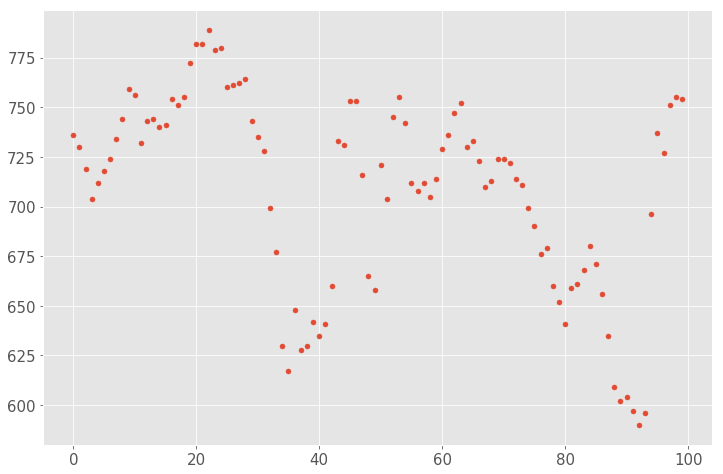

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(100), y = NNIntervals[:100])

##  Interpolation du signal

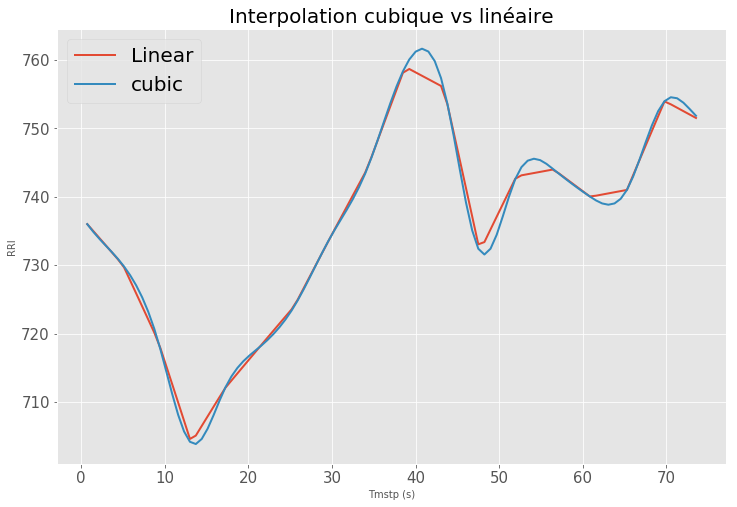

In [11]:
# ---------- Interpolation du signal linéaire ---------- #

timestamps = create_time_info(NNIntervals)
function = interpolate.interp1d(x = timestamps, y = NNIntervals, 
                             kind = 'linear')
    
timestamps_interpolation = create_interpolation_time(NNIntervals, sampling_frequency = 8)
NNI_interpolation_linear = function(timestamps_interpolation)

# ---------- Interpolation du signal cubique ---------- #

timestamps = create_time_info(NNIntervals)
function = interpolate.interp1d(x = timestamps, y = NNIntervals, 
                             kind = 'cubic')
    
timestamps_interpolation = create_interpolation_time(NNIntervals, sampling_frequency = 8)
NNI_interpolation_cubic = function(timestamps_interpolation)

# ---------- Plot ---------- #
y = np.cumsum(NNI_interpolation_cubic[:100])/1000
plt.figure(figsize=(12,8))
plt.title("Interpolation cubique vs linéaire")
plt.plot(y, NNI_interpolation_linear[:100], label = "Linear")
plt.plot(y, NNI_interpolation_cubic[:100], label = "cubic")
plt.ylabel('RRI')
plt.xlabel('Tmstp (s)')
plt.legend(loc = "best")
plt.show()

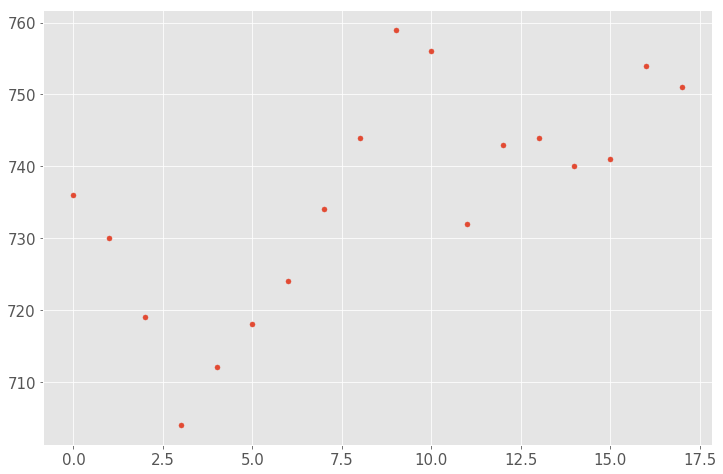

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(18), y = NNIntervals[:18])

# Calcul de la PSD - FFT / Welch

In [33]:
#  ---------- Removing DC Component ---------- #
RRseries = NNI_interpolation_linear - np.mean(NNI_interpolation_linear)

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "image.png", width=600, height=600)

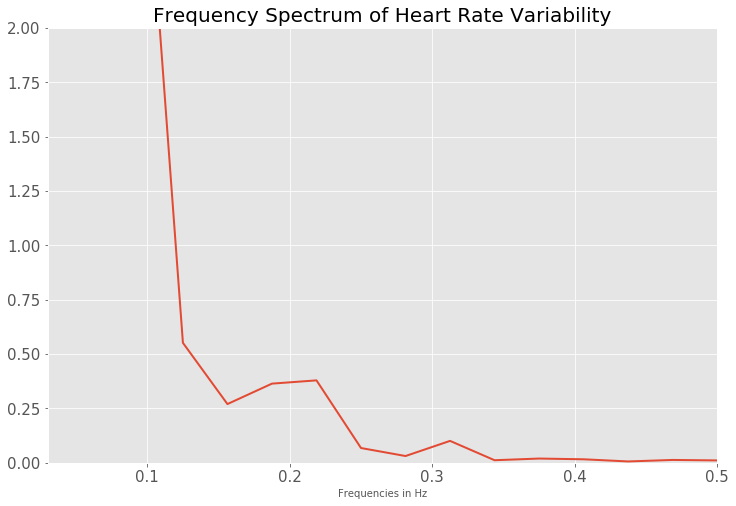

In [41]:
#  ----------  Calcul PSD  ---------- #
freq, Pxx = signal.welch(x = RRseries[:1000], fs = 4, window = 'hann')

#Plot
plt.figure(figsize=(12,8))
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0.03, 0.5) 
# For visibility
plt.ylim(0, 2)# 
plt.plot(freq[::2], abs(Pxx[::2]) / n) 
plt.xlabel("Frequencies in Hz")
plt.show()

In [32]:
Image(url= "psd.png", width=600, height=600)

In [14]:
get_frequency_domain_features(NNIntervals)

{'total_power': 488.2086516182612,
 'VLF': 0.0,
 'LF': 327.45531909303725,
 'HF': 160.75333252522393,
 'LF_HR_ratio': 2.0370048567525405,
 'LFnu': 67.07282183706164,
 'HFnu': 32.92717816293836}

# Non Linear Domain Features

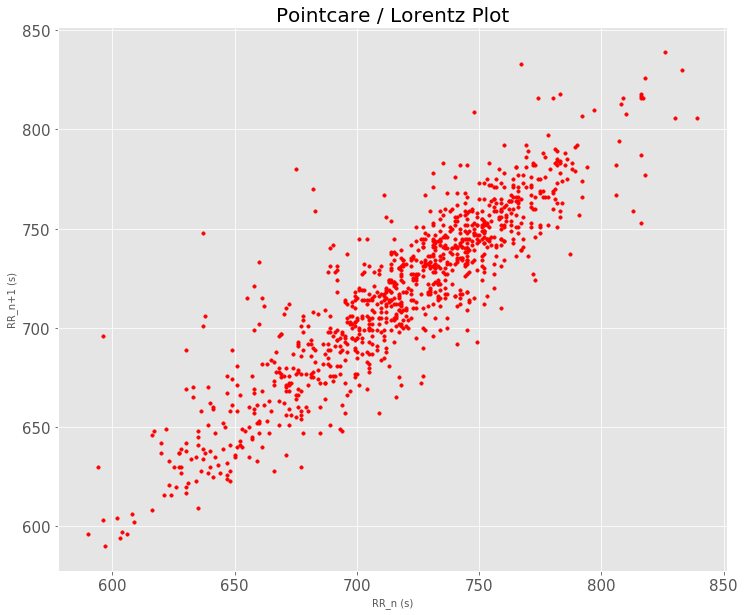

In [16]:
def plotPoincare(NNIntervals):
    """
    Plot the Pointcare / Lorentz Plot
    
    Arguments
    ---------
    NNIntervals - list of NN intervals
        
    Returns
    ---------
    Poincare plot  

    Notes
    ---------
    The transverse axis (T) reflects beat-to-beat variation
    the longitudinal axis (L) reflects the overall fluctuation
    """
    ax1 = RRints[:-1]
    ax2 = RRints[1:]   
    
    plt.figure(figsize=(12,10))
    plt.title("Pointcare / Lorentz Plot", )
    plt.scatter(ax1, ax2, c = 'r', s = 12)
    plt.xlabel('RR_n (s)')
    plt.ylabel('RR_n+1 (s)')
    plt.show()
    
plotPoincare(NNIntervals)

In [17]:
Image(url= "pointcareplot.png", 
      width=800, height=800)

In [18]:
def get_csi_cvi_features(NNIntervals):
    """
    Function returning a dictionnary containing 3 features from non linear domain  
    for HRV analyses.
    Must use this function on short term recordings, for 30 , 50, 100 Rr Intervals 
    or seconds window.

    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval

    Returns
    ---------
    csi_cvi_features - dictionnary containing non linear domain features 
    for HRV analyses. Thera are details about each features are given below. 
    
    Notes
    ---------
    - **CSI** : 
    - **CVI** : 
    - **Modified_CSI** : 
    
    References
    ----------
    TO DO    
    """
    
    # Measures the width and length of poincare cloud
    poincare_plot_features = get_poincare_plot_features(NNIntervals)
    T = 4 * poincare_plot_features['SD1']
    L = 4 * poincare_plot_features['SD2']
    
    CSI = L / T
    CVI = np.log10(L * T)
    Modified_CSI = L**2 / T
    
    csi_cvi_features = {
        'CSI' : CSI,
        'CVI' : CVI,
        'Modified_CSI' : Modified_CSI
    }
    
    return csi_cvi_features

def get_poincare_plot_features(NNIntervals):
    """
    Function returning a dictionnary containing 3 features from non linear domain  
    for HRV analyses.
    Must use this function on short term recordings, from 5 minutes window.

    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval

    Returns
    ---------
    poincare_plot_features - dictionnary containing non linear domain features 
    for HRV analyses. Thera are details about each features are given below. 
    
    Notes
    ---------
    - **SD1** : 
    - **SD2** : 
    - **ratio_SD1_SD2** : 
    
    References
    ----------
    TO DO   
    """
    diff_NNIntervals = np.diff(NNIntervals)
    #measures the width of poincare cloud
    SD1 = np.sqrt(np.std(diff_NNIntervals, ddof=1) ** 2 * 0.5)
    #measures the length of the poincare cloud
    SD2 = np.sqrt(2 * np.std(NNIntervals, ddof=1) ** 2 - 0.5 * np.std(diff_NNIntervals,
                                                              ddof=1) ** 2)
    ratio_SD1_SD2 = SD1 / SD2
    
    poincare_plot_features = {
        'SD1' : SD1,
        'SD2' : SD2,
        'ratio_SD1_SD2' : ratio_SD1_SD2
    }

    return poincare_plot_features

def get_sampen(NNIntervals):
    """
    Must use this function on short term recordings, from 1 minute window.
    TO DO
    """
    SampEn = nolds.sampen(NNIntervals, emb_dim = 2)
    return {'Sampen' : SampEn}

print(get_csi_cvi_features(NNIntervals))
print()
print(get_poincare_plot_features(NNIntervals))
print()
print(get_sampen(NNIntervals))

{'CSI': 4.300520404060338, 'CVI': 4.117977429005704, 'Modified_CSI': 1021.5749458778378}

{'SD1': 13.80919037557993, 'SD2': 59.38670497373513, 'ratio_SD1_SD2': 0.2325299977779084}

{'Sampen': 1.2046675751816824}
